In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# reading csv files
SP500_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/823/data/Dateset_Apr_2022.csv', index_col=False)
SP500_df.head()

,Unnamed: 0,data_date,AAPL_open,AAPL_high,AAPL_low,AAPL_close,AAPL_adj_close,AAPL_volume,AAPL_dividend_amount,AAPL_split_coefficient,...,UNH_adj_close,UNH_volume,UNH_dividend_amount,UNH_split_coefficient,SP500_high,SP500_low,SP500_open,SP500_close,SP500_volume,SP500_adj_close
0,0,2014-03-27,540.015,541.5000,535.1201,537.46,17.099063,7929700.0,0.0,1.0,...,71.577427,5453900.0,0.0,1.0,1855.550049,1842.109985,1852.109985,1849.040039,3733430000,1849.040039
1,1,2014-03-28,538.320,538.9399,534.2500,536.86,17.079974,7163000.0,0.0,1.0,...,72.107500,4787400.0,0.0,1.0,1866.630005,1850.069946,1850.069946,1857.619995,2955520000,1857.619995
2,2,2014-03-31,539.230,540.8100,535.9300,536.74,17.076156,6023900.0,0.0,1.0,...,72.434378,3513700.0,0.0,1.0,1875.180054,1859.160034,1859.160034,1872.339966,3274300000,1872.339966
3,3,2014-04-01,537.760,541.8700,536.7700,541.65,17.232366,7170000.0,0.0,1.0,...,72.301860,4339800.0,0.0,1.0,1885.839966,1873.959961,1873.959961,1885.520020,3336190000,1885.520020
4,4,2014-04-02,542.380,543.4800,540.2600,542.55,17.260999,6443600.0,0.0,1.0,...,72.098665,3832100.0,0.0,1.0,1893.170044,1883.790039,1886.609985,1890.900024,3131660000,1890.900024


In [ ]:
#@title Load Python libraries

# pip install numpy
import numpy as np

# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

print("All libraries loaded")

All libraries loaded


In [ ]:
config = {
    "alpha_vantage": {
        "key": "MU477ESE3EQUUFS3", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
        "symbol": "SPX", # obseleted
        "outputsize": "full",
        "key_open": "1. open",
        "key_high": "2. high",
        "key_low": "3. low",
        "key_close": "4. close",
        "key_adjusted_close": "5. adjusted close",
        "key_volume": "6. volume",
        "key_dividend_amount": "7. dividend amount",
        "key_split_coefficient": "8. split coefficient"
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 10, # since we are using 10 feature, top 10 holding's close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cuda", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

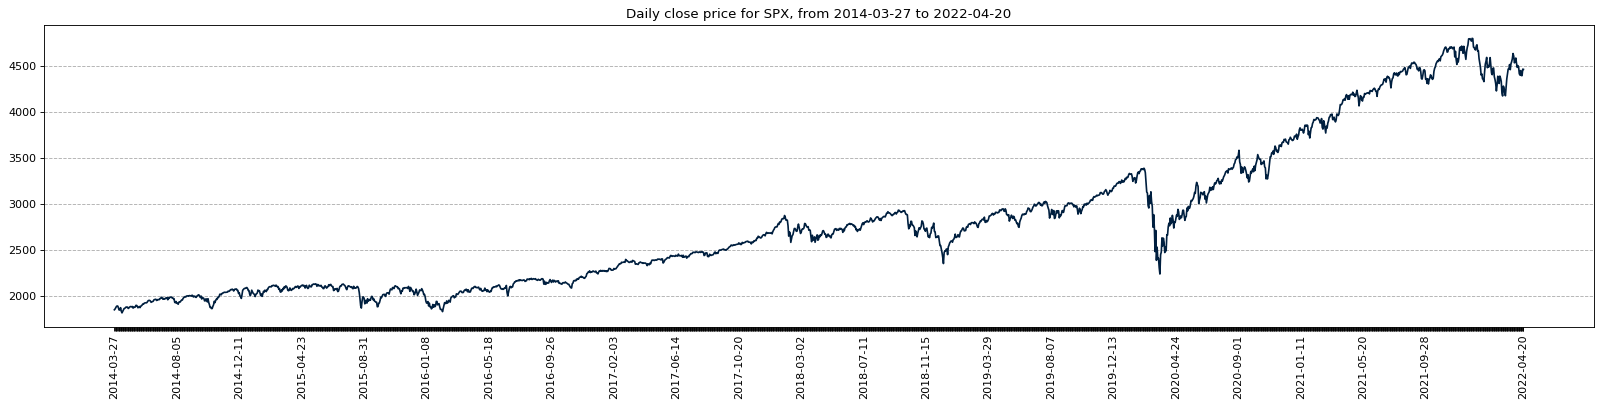

In [ ]:
num_data_points = len(SP500_df["data_date"])
display_date_range = "from " + SP500_df["data_date"][0] + " to " + SP500_df["data_date"][num_data_points-1]

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(SP500_df["data_date"], SP500_df["SP500_close"], color=config["plots"]["color_actual"])
xticks = [SP500_df["data_date"][i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.show()

In [ ]:
def print_column_index(df, col_name):
  index_no = df.columns.get_loc(col_name)
  print("Index of {} column in given dataframe is : {}".format(col_name, index_no))

print_column_index(SP500_df, "AAPL_adj_close")
print_column_index(SP500_df, "MSFT_adj_close")
print_column_index(SP500_df, "AMZN_adj_close")
print_column_index(SP500_df, "TSLA_adj_close")
print_column_index(SP500_df, "GOOGL_adj_close")
print_column_index(SP500_df, "GOOG_adj_close")
print_column_index(SP500_df, "NVDA_adj_close")
print_column_index(SP500_df, "BRK_B_adj_close")
print_column_index(SP500_df, "FB_adj_close")
print_column_index(SP500_df, "UNH_adj_close")
print_column_index(SP500_df, "SP500_adj_close")

Index of AAPL_adj_close column in given dataframe is : 6
Index of MSFT_adj_close column in given dataframe is : 14
Index of AMZN_adj_close column in given dataframe is : 22
Index of TSLA_adj_close column in given dataframe is : 30
Index of GOOGL_adj_close column in given dataframe is : 38
Index of GOOG_adj_close column in given dataframe is : 46
Index of NVDA_adj_close column in given dataframe is : 54
Index of BRK_B_adj_close column in given dataframe is : 62
Index of FB_adj_close column in given dataframe is : 70
Index of UNH_adj_close column in given dataframe is : 78
Index of SP500_adj_close column in given dataframe is : 87


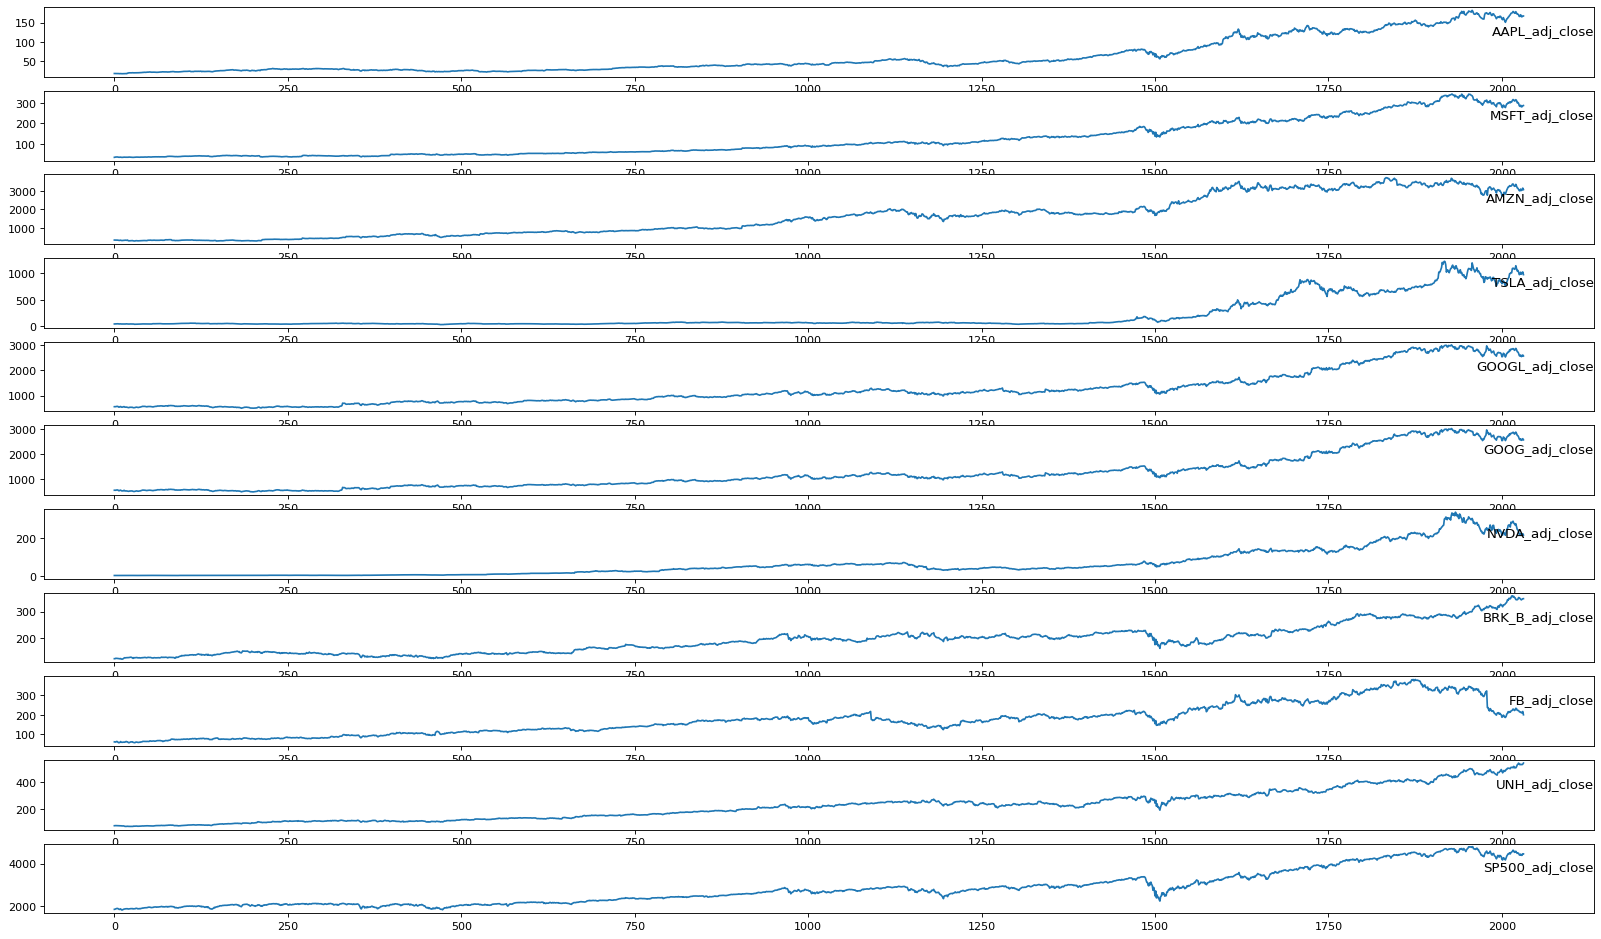

In [ ]:
# load dataset
values = SP500_df.values
# specify columns to plot
groups = [6, 14, 22, 30, 38, 46, 54, 62, 70, 78, 87]
i = 1
# plot each column
plt.figure(figsize=(25, 15), dpi=80)
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(SP500_df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

# Data preparation: normalizing raw financial data

In [ ]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
# top10_list = ["AAPL", "MSFT", "AMZN", "TSLA", "GOOGL", "GOOG", "NVDA", "BRK.B", "FB", "UNH"]

scaler = Normalizer()
normalized_AAPL_close_price = scaler.fit_transform(SP500_df["AAPL_adj_close"].to_numpy())
normalized_MSFT_close_price = scaler.fit_transform(SP500_df["MSFT_adj_close"].to_numpy())
normalized_AMZN_close_price = scaler.fit_transform(SP500_df["AMZN_adj_close"].to_numpy())
normalized_TSLA_close_price = scaler.fit_transform(SP500_df["TSLA_adj_close"].to_numpy())
normalized_GOOGL_close_price = scaler.fit_transform(SP500_df["GOOGL_adj_close"].to_numpy())
normalized_GOOG_close_price = scaler.fit_transform(SP500_df["GOOG_adj_close"].to_numpy())
normalized_NVDA_close_price = scaler.fit_transform(SP500_df["NVDA_adj_close"].to_numpy())
normalized_BRK_B_close_price = scaler.fit_transform(SP500_df["BRK_B_adj_close"].to_numpy())
normalized_FB_close_price = scaler.fit_transform(SP500_df["FB_adj_close"].to_numpy())
normalized_UNH_close_price = scaler.fit_transform(SP500_df["UNH_adj_close"].to_numpy())
normalized_SP500_close_price = scaler.fit_transform(SP500_df["SP500_adj_close"].to_numpy())


In [ ]:
normalized_AAPL_close_price_df = pd.DataFrame(normalized_AAPL_close_price)
normalized_MSFT_close_price_df = pd.DataFrame(normalized_MSFT_close_price)
normalized_AMZN_close_price_df = pd.DataFrame(normalized_AMZN_close_price)
normalized_TSLA_close_price_df = pd.DataFrame(normalized_TSLA_close_price)
normalized_GOOGL_close_price_df = pd.DataFrame(normalized_GOOGL_close_price)
normalized_GOOG_close_price_df = pd.DataFrame(normalized_GOOG_close_price)
normalized_NVDA_close_price_df = pd.DataFrame(normalized_NVDA_close_price)
normalized_BRK_B_close_price_df = pd.DataFrame(normalized_BRK_B_close_price)
normalized_FB_close_price_df = pd.DataFrame(normalized_FB_close_price)
normalized_UNH_close_price_df = pd.DataFrame(normalized_UNH_close_price)
normalized_SP500_close_price_df = pd.DataFrame(normalized_SP500_close_price)

normalized_df=pd.concat([normalized_AAPL_close_price_df,
                         normalized_MSFT_close_price_df,
                         normalized_AMZN_close_price_df,
                         normalized_TSLA_close_price_df,
                         normalized_GOOGL_close_price_df,
                         normalized_GOOG_close_price_df,
                         normalized_NVDA_close_price_df,
                         normalized_BRK_B_close_price_df,
                         normalized_FB_close_price_df,
                         normalized_UNH_close_price_df,
                         normalized_SP500_close_price_df],
                        axis=1)
print(normalized_df)


             0         0         0         0         0         0         0  \
0    -0.958521 -0.995427 -1.174911 -0.559024 -1.002112 -0.976355 -0.839204   
1    -0.958945 -0.986037 -1.175081 -0.555585 -0.997648 -0.974078 -0.838847   
2    -0.959030 -0.979145 -1.176897 -0.558254 -1.001937 -0.978573 -0.838814   
3    -0.955558 -0.974850 -1.170646 -0.552453 -0.986440 -0.963406 -0.836410   
4    -0.954921 -0.975549 -1.171618 -0.543382 -0.986280 -0.963644 -0.836800   
...        ...       ...       ...       ...       ...       ...       ...   
2027  2.448954  1.943140  1.440722  2.780786  2.089298  2.070837  2.143215   
2028  2.335372  1.852903  1.368368  2.653548  1.993357  1.980550  2.013818   
2029  2.330482  1.860896  1.388718  2.719227  2.022058  2.001626  2.085705   
2030  2.382272  1.916266  1.489302  2.800466  2.092785  2.078131  2.142530   
2031  2.378493  1.928545  1.411607  2.626990  2.033080  2.010095  2.044490   

             0         0         0         0  
0    -1.325638 -

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
reframed_df = series_to_supervised(normalized_df, 1, 1)
# drop columns we don't want to predict
reframed_df.drop(reframed_df.columns[[11,12,13,14,15,16,17,18,19,20,21]], axis=1, inplace=True)
print(reframed_df.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1  -0.958521  -0.995427  -1.174911  -0.559024  -1.002112  -0.976355   
2  -0.958945  -0.986037  -1.175081  -0.555585  -0.997648  -0.974078   
3  -0.959030  -0.979145  -1.176897  -0.558254  -1.001937  -0.978573   
4  -0.955558  -0.974850  -1.170646  -0.552453  -0.986440  -0.963406   
5  -0.954921  -0.975549  -1.171618  -0.543382  -0.986280  -0.963644   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  
1  -0.839204  -1.325638  -1.418850   -1.303688   -1.191606  
2  -0.838847  -1.324479  -1.430970   -1.299031   -1.180866  
3  -0.838814  -1.296667  -1.428066   -1.296160   -1.162441  
4  -0.836410  -1.298405  -1.398017   -1.297324   -1.145943  
5  -0.836800  -1.306324  -1.396755   -1.299109   -1.139208  


In [ ]:
print(reframed_df.tail())

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2027   2.388051   1.878735   1.351027   2.660187   2.023210   2.013935   
2028   2.448954   1.943140   1.440722   2.780786   2.089298   2.070837   
2029   2.335372   1.852903   1.368368   2.653548   1.993357   1.980550   
2030   2.330482   1.860896   1.388718   2.719227   2.022058   2.001626   
2031   2.382272   1.916266   1.489302   2.800466   2.092785   2.078131   

      var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  
2027   2.047502   3.044533   0.515020    2.755874    1.998328  
2028   2.143215   2.976548   0.525752    2.784775    2.059838  
2029   2.013818   2.940044   0.465023    2.765625    1.992244  
2030   2.085705   2.984853   0.472472    2.759125    1.991118  
2031   2.142530   3.020584   0.555043    2.790924    2.079390  


In [ ]:
reframed_df.shape

(2031, 11)

# Data preparation: generating training and validation datasets

Divide each of top10 holdings'features into training and validation sets

In [ ]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

def prepare_data(symbol, normalized_data_value, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_value, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_value, window_size=config["data"]["window_size"])

    # split dataset

    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # prepare data for plotting

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)

        to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
        #+1 for the odd number
        to_plot_data_y_val[split_index+config["data"]["window_size"]+1:] = scaler.inverse_transform(data_y_val)

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        ## plots

        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(SP500_df["data_date"], to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
        plt.plot(SP500_df["data_date"], to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
        xticks = [SP500_df["data_date"][i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close prices for " + symbol + " - showing training and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen


1. AAPL's Adj Close Price

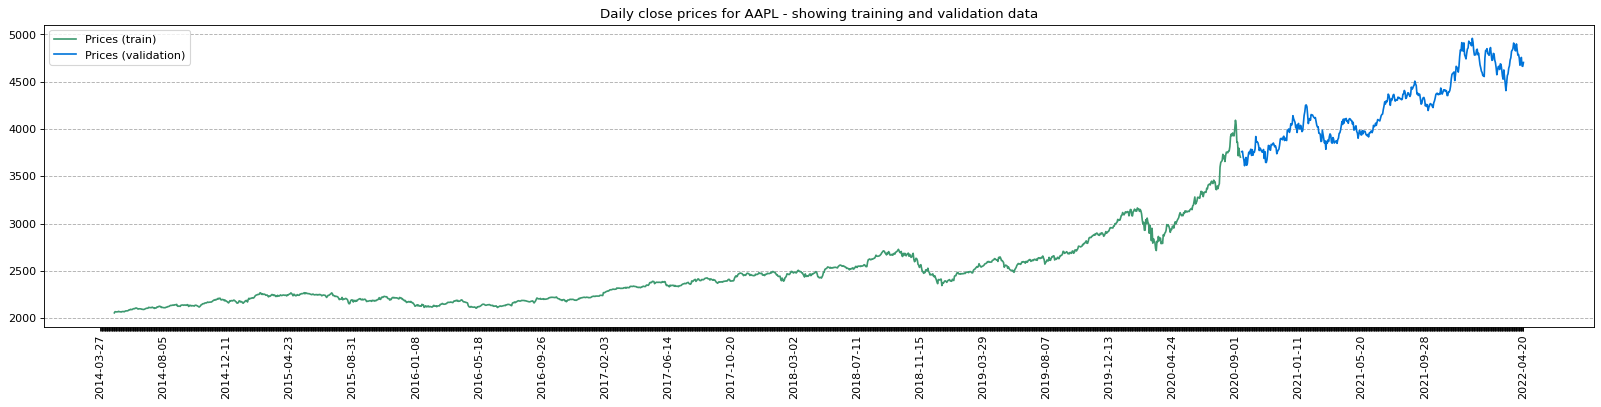

In [ ]:
split_index, AAPL_x_train, AAPL_y_train, AAPL_x_val, AAPL_y_val, AAPL_x_unseen = prepare_data('AAPL', reframed_df['var1(t-1)'].values, config, plot=config["plots"]["show_plots"])

2. MSFT's Adj Close Price

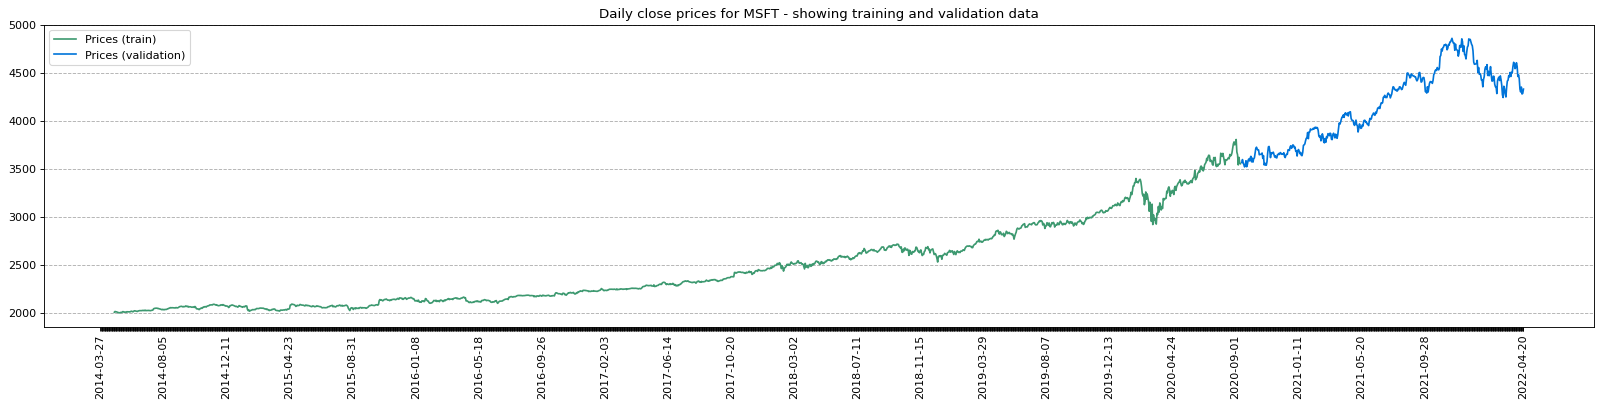

In [ ]:
split_index, MSFT_x_train, MSFT_y_train, MSFT_x_val, MSFT_y_val, MSFT_x_unseen = prepare_data('MSFT', reframed_df['var2(t-1)'].values, config, plot=config["plots"]["show_plots"])

3. AMZN's Adj Close Price

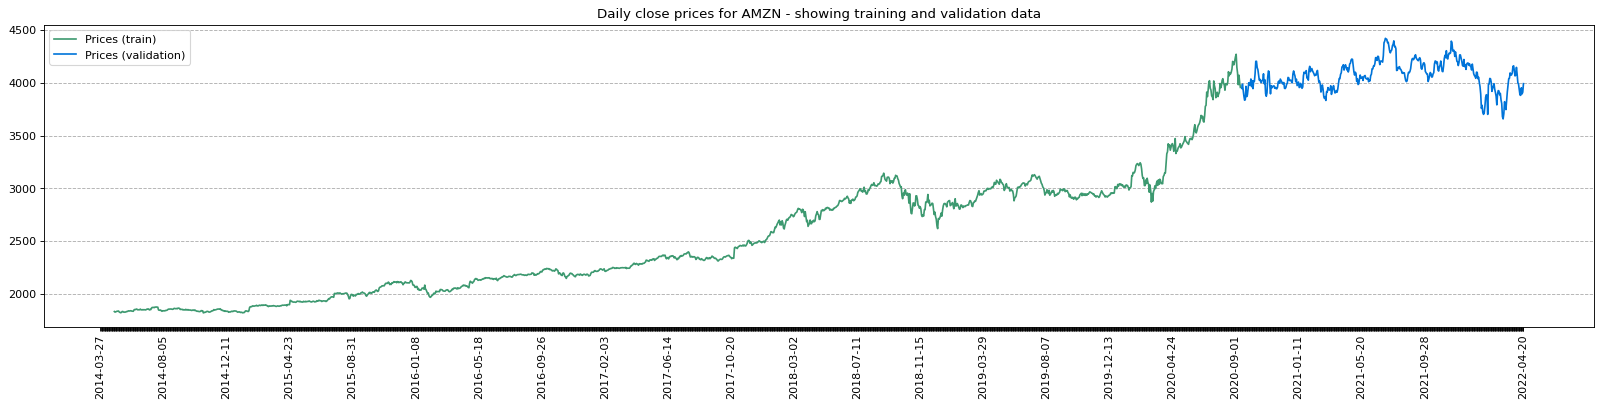

In [ ]:
split_index, AMZN_x_train, AMZN_y_train, AMZN_x_val, AMZN_y_val, AMZN_x_unseen = prepare_data('AMZN', reframed_df['var3(t-1)'].values, config, plot=config["plots"]["show_plots"])

4. TSLA's Adj Close Price

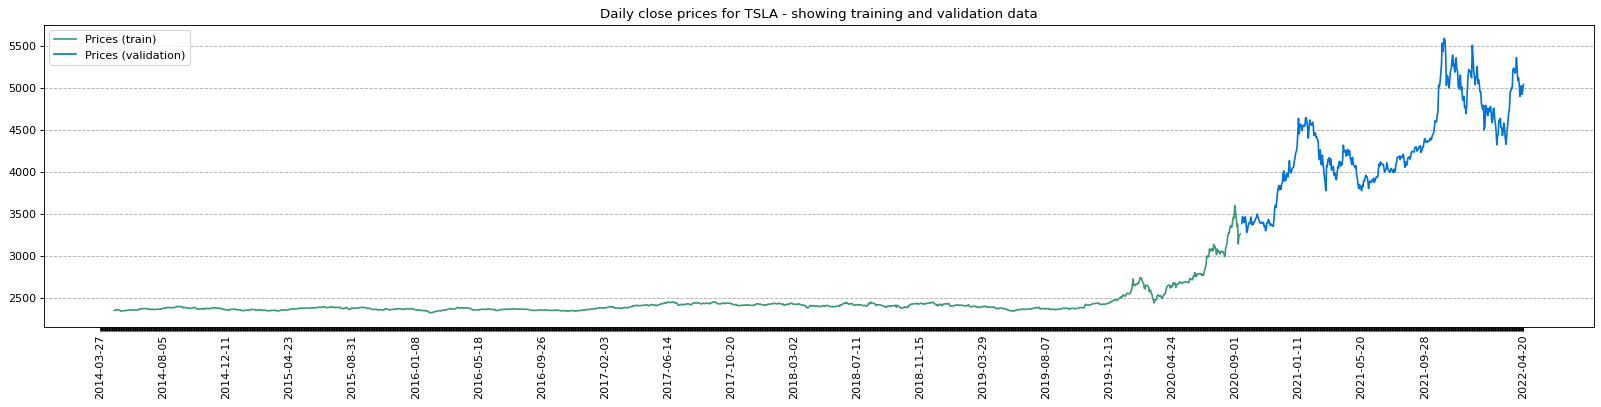

In [ ]:
split_index, TSLA_x_train, TSLA_y_train, TSLA_x_val, TSLA_y_val, TSLA_x_unseen = prepare_data('TSLA', reframed_df['var4(t-1)'].values, config, plot=config["plots"]["show_plots"])

5. GOOGL's Adj Close Price

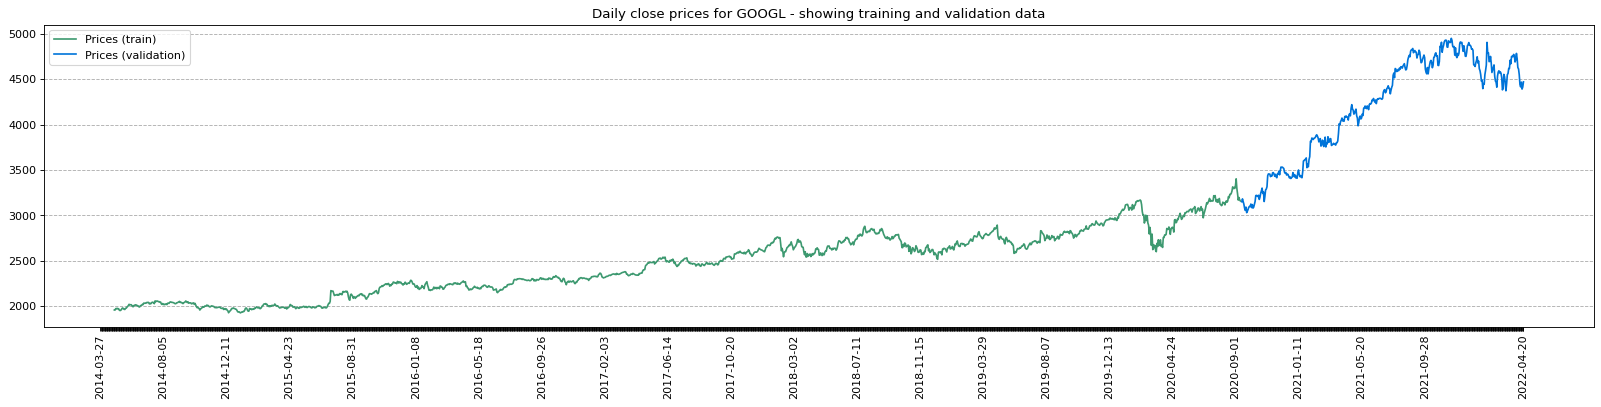

In [ ]:
split_index, GOOGL_x_train, GOOGL_y_train, GOOGL_x_val, GOOGL_y_val, GOOGL_x_unseen = prepare_data('GOOGL', reframed_df['var5(t-1)'].values, config, plot=config["plots"]["show_plots"])

6. GOOG's Adj Close Price

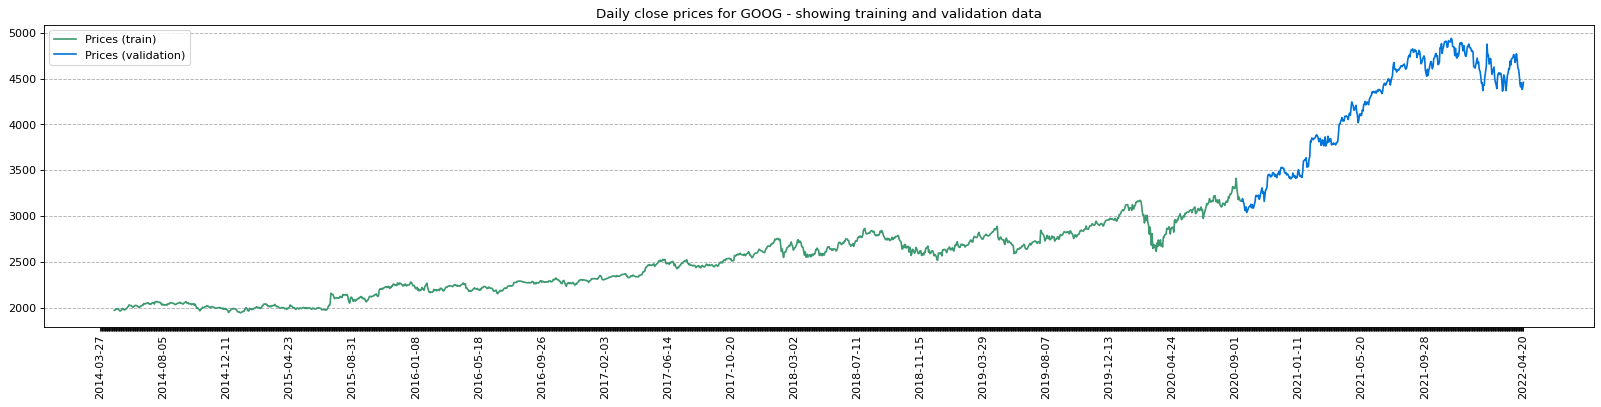

In [ ]:
split_index, GOOG_x_train, GOOG_y_train, GOOG_x_val, GOOG_y_val, GOOG_x_unseen = prepare_data('GOOG', reframed_df['var6(t-1)'].values, config, plot=config["plots"]["show_plots"])

7. NVDA's Adj Close Price

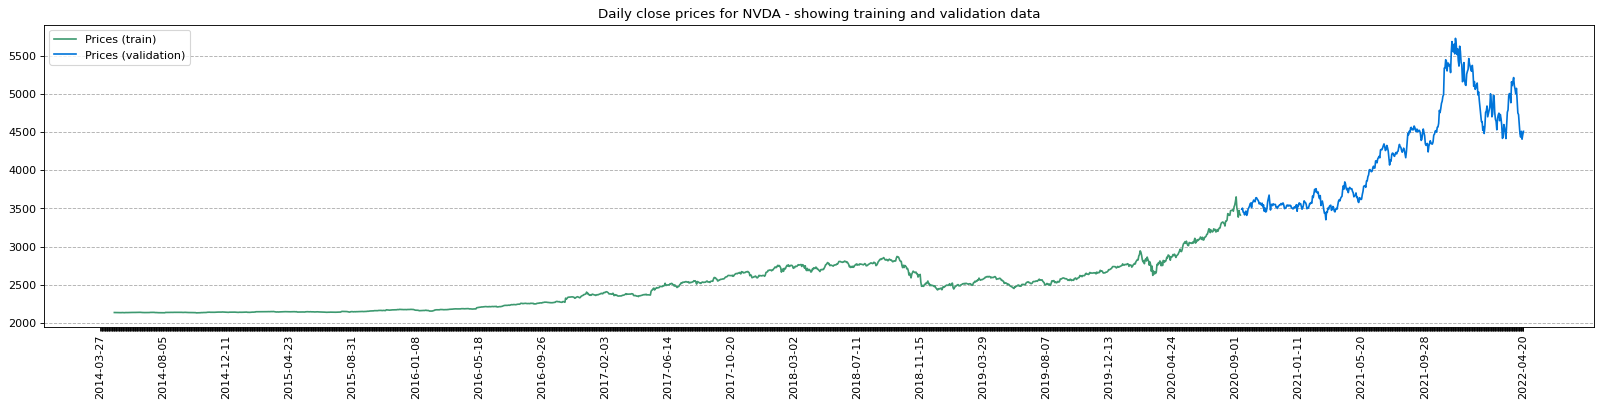

In [ ]:
split_index, NVDA_x_train, NVDA_y_train, NVDA_x_val, NVDA_y_val, NVDA_x_unseen = prepare_data('NVDA', reframed_df['var7(t-1)'].values, config, plot=config["plots"]["show_plots"])

8. BRK.B's Adj Close Price

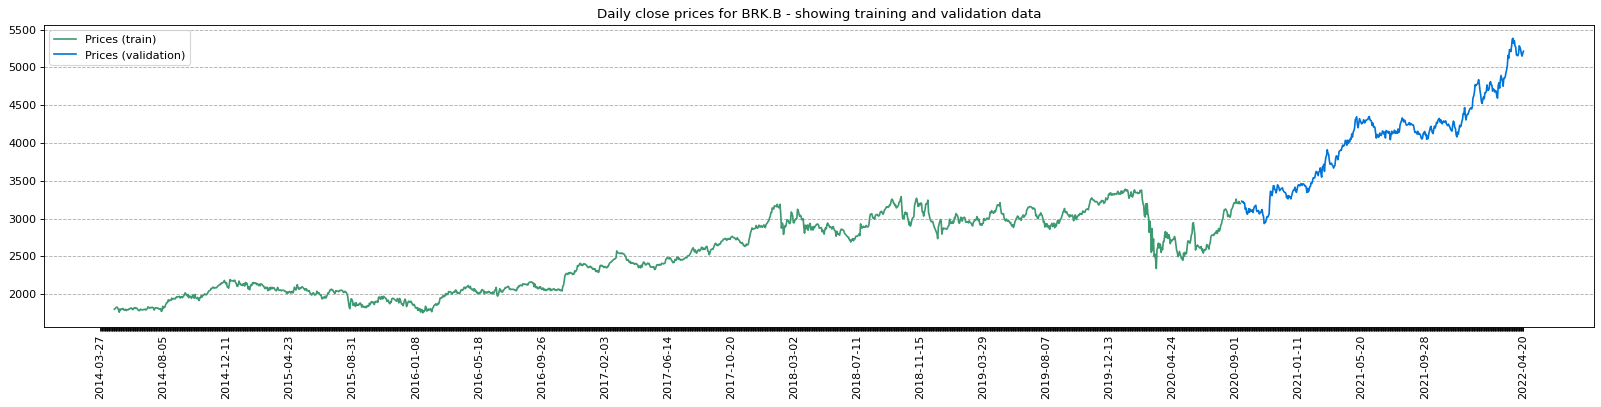

In [ ]:
split_index, BRK_B_x_train, BRK_B_y_train, BRK_B_x_val, BRK_B_y_val, BRK_B_x_unseen = prepare_data('BRK.B', reframed_df['var8(t-1)'].values, config, plot=config["plots"]["show_plots"])

9. FB's Adj Close Price

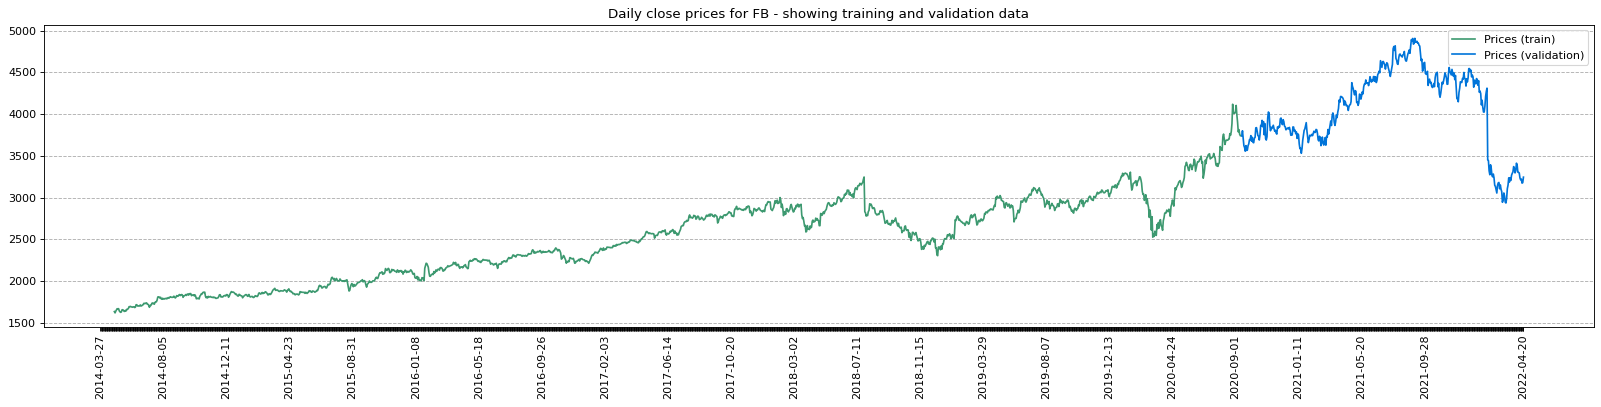

In [ ]:
split_index, FB_x_train, FB_y_train, FB_x_val, FB_y_val, FB_x_unseen = prepare_data('FB', reframed_df['var9(t-1)'].values, config, plot=config["plots"]["show_plots"])

10. UNH's Adj Close Price

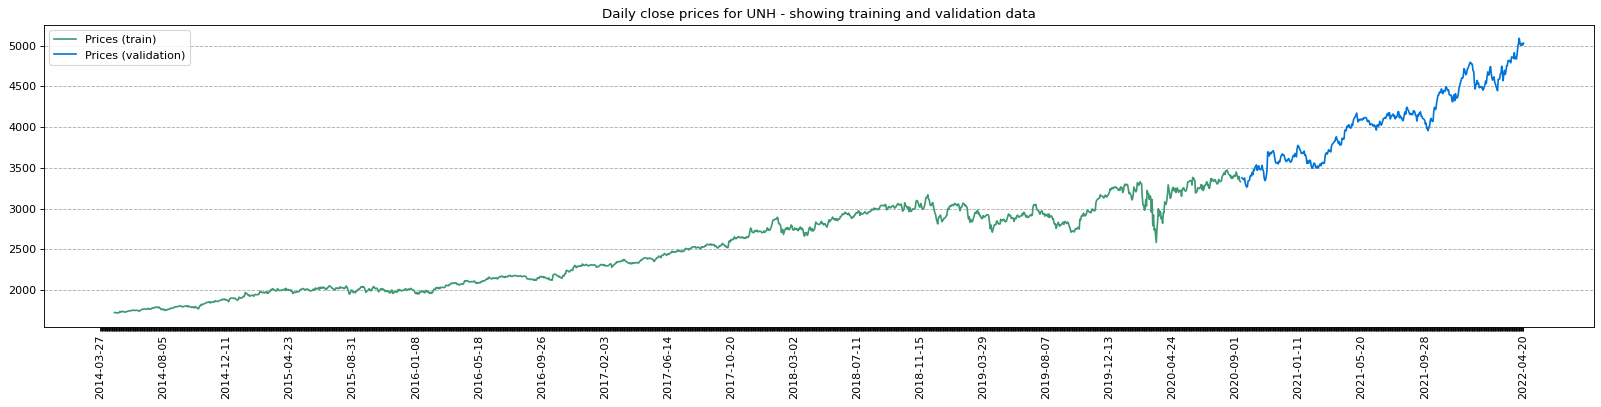

In [ ]:
split_index, UNH_x_train, UNH_y_train, UNH_x_val, UNH_y_val, UNH_x_unseen = prepare_data('UNH', reframed_df['var10(t-1)'].values, config, plot=config["plots"]["show_plots"])

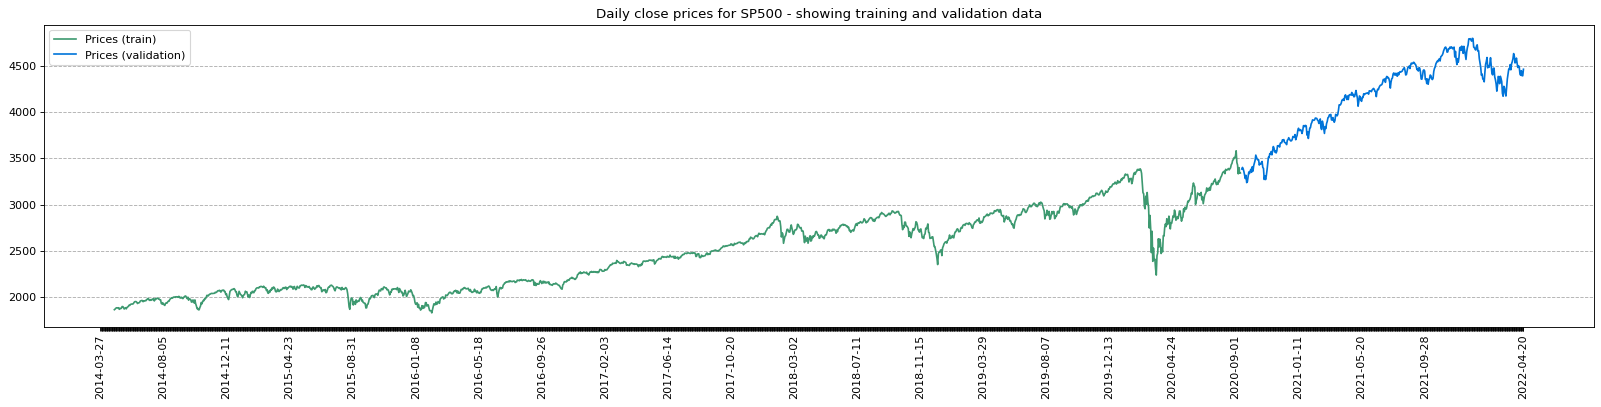

In [ ]:
split_index, SP500_x_train, SP500_y_train, SP500_x_val, SP500_y_val, SP500_x_unseen = prepare_data('SP500', reframed_df['var11(t-1)'].values, config, plot=config["plots"]["show_plots"])

In [ ]:
result_x_train = np.concatenate([np.expand_dims(AAPL_x_train, 2),
                                 np.expand_dims(MSFT_x_train, 2), 
                                 np.expand_dims(AMZN_x_train, 2),
                                 np.expand_dims(TSLA_x_train, 2),
                                 np.expand_dims(MSFT_x_train, 2),
                                 np.expand_dims(GOOGL_x_train, 2),
                                 np.expand_dims(GOOG_x_train, 2),
                                 np.expand_dims(BRK_B_x_train, 2),
                                 np.expand_dims(FB_x_train, 2), 
                                 np.expand_dims(UNH_x_train, 2)], 
                                axis=2)

result_x_val = np.concatenate([np.expand_dims(AAPL_x_val, 2),
                                 np.expand_dims(MSFT_x_val, 2), 
                                 np.expand_dims(AMZN_x_val, 2),
                                 np.expand_dims(TSLA_x_val, 2),
                                 np.expand_dims(MSFT_x_val, 2),
                                 np.expand_dims(GOOGL_x_val, 2),
                                 np.expand_dims(GOOG_x_val, 2),
                                 np.expand_dims(BRK_B_x_val, 2),
                                 np.expand_dims(FB_x_val, 2), 
                                 np.expand_dims(UNH_x_val, 2)], 
                                axis=2)

In [ ]:
result_x_train.shape

(1608, 20, 10)

In [ ]:
result_x_val.shape

(403, 20, 10)

In [ ]:
# ["AAPL", "MSFT", "AMZN", "TSLA", "GOOGL", "GOOG", "GOOG", "BRK.B", "FB", "UNH"]

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        # x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(result_x_train, SP500_y_train)
dataset_val = TimeSeriesDataset(result_x_val, SP500_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (1608, 20, 10) (1608,)
Validation data shape (403, 20, 10) (403,)


# Defining the LSTM model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

# Model training

In [ ]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))


Epoch[1/100] | loss train:0.023312, test:0.142412 | lr:0.010000
Epoch[2/100] | loss train:0.004864, test:0.128960 | lr:0.010000
Epoch[3/100] | loss train:0.003390, test:0.137212 | lr:0.010000
Epoch[4/100] | loss train:0.003382, test:0.108180 | lr:0.010000
Epoch[5/100] | loss train:0.002793, test:0.117633 | lr:0.010000
Epoch[6/100] | loss train:0.004504, test:0.156576 | lr:0.010000
Epoch[7/100] | loss train:0.002999, test:0.085130 | lr:0.010000
Epoch[8/100] | loss train:0.003659, test:0.072554 | lr:0.010000
Epoch[9/100] | loss train:0.002937, test:0.128511 | lr:0.010000
Epoch[10/100] | loss train:0.002694, test:0.091691 | lr:0.010000
Epoch[11/100] | loss train:0.002802, test:0.118234 | lr:0.010000
Epoch[12/100] | loss train:0.002491, test:0.115529 | lr:0.010000
Epoch[13/100] | loss train:0.002572, test:0.125238 | lr:0.010000
Epoch[14/100] | loss train:0.002343, test:0.119677 | lr:0.010000
Epoch[15/100] | loss train:0.002968, test:0.116724 | lr:0.010000
Epoch[16/100] | loss train:0.00255

# Model evaluation

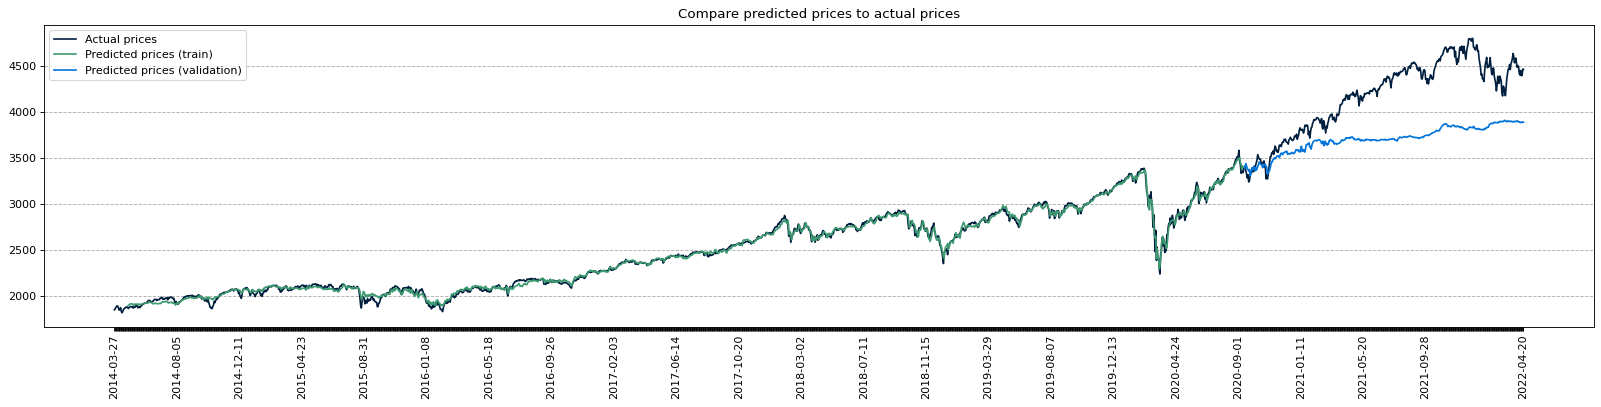

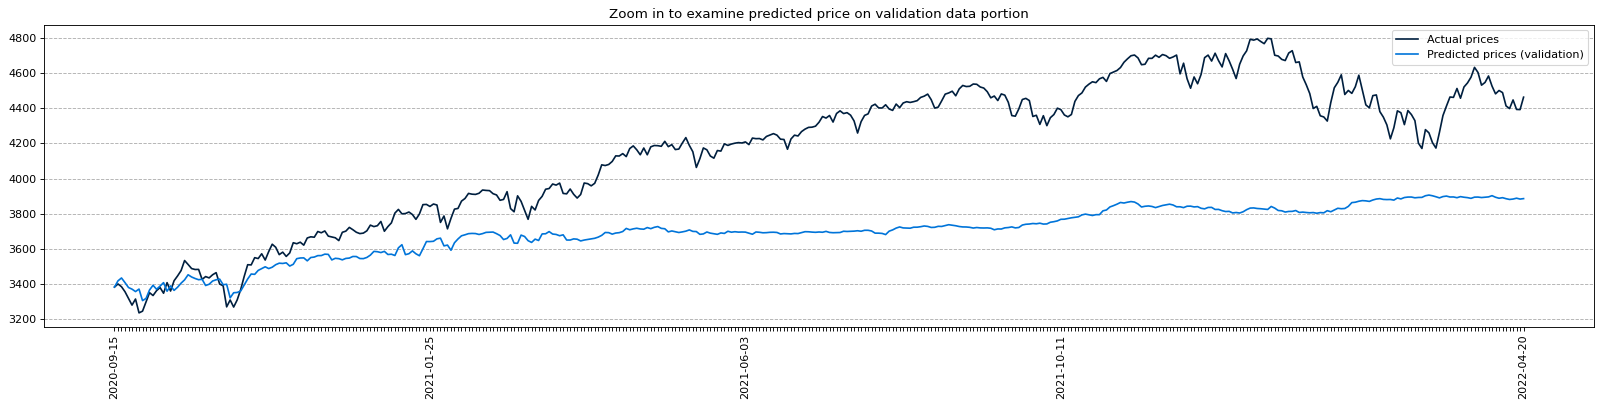

In [ ]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]+1:] = scaler.inverse_transform(predicted_val)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(SP500_df["data_date"], SP500_df["SP500_adj_close"], label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(SP500_df["data_date"], to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
    plt.plot(SP500_df["data_date"], to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Compare predicted prices to actual prices")
    xticks = [SP500_df["data_date"][i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation

    to_plot_data_y_val_subset = scaler.inverse_transform(SP500_y_val)
    to_plot_predicted_val = scaler.inverse_transform(predicted_val)
    to_plot_data_date = SP500_df["data_date"][split_index+config["data"]["window_size"]+1:]

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Zoom in to examine predicted price on validation data portion")    
    xticks = [to_plot_data_date.iloc[i] if ((i%config["plots"]["xticks_interval"]==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice    
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

# Predicting future stock prices

In [ ]:
SP500_x_unseen_modified = np.concatenate([np.expand_dims(AAPL_x_unseen, 1),
                                          np.expand_dims(MSFT_x_unseen, 1), 
                                          np.expand_dims(AMZN_x_unseen, 1),
                                          np.expand_dims(TSLA_x_unseen, 1),
                                          np.expand_dims(MSFT_x_unseen, 1),
                                          np.expand_dims(GOOGL_x_unseen, 1),
                                          np.expand_dims(GOOG_x_unseen, 1),
                                          np.expand_dims(BRK_B_x_unseen, 1),
                                          np.expand_dims(FB_x_unseen, 1), 
                                          np.expand_dims(UNH_x_unseen, 1)], 
                                          axis=1)

In [ ]:
SP500_x_unseen_modified.shape

(20, 10)

In [ ]:
model.eval()

x = torch.tensor(SP500_x_unseen_modified).float().to(config["training"]["device"]).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]

x.shape

torch.Size([20, 1, 1])

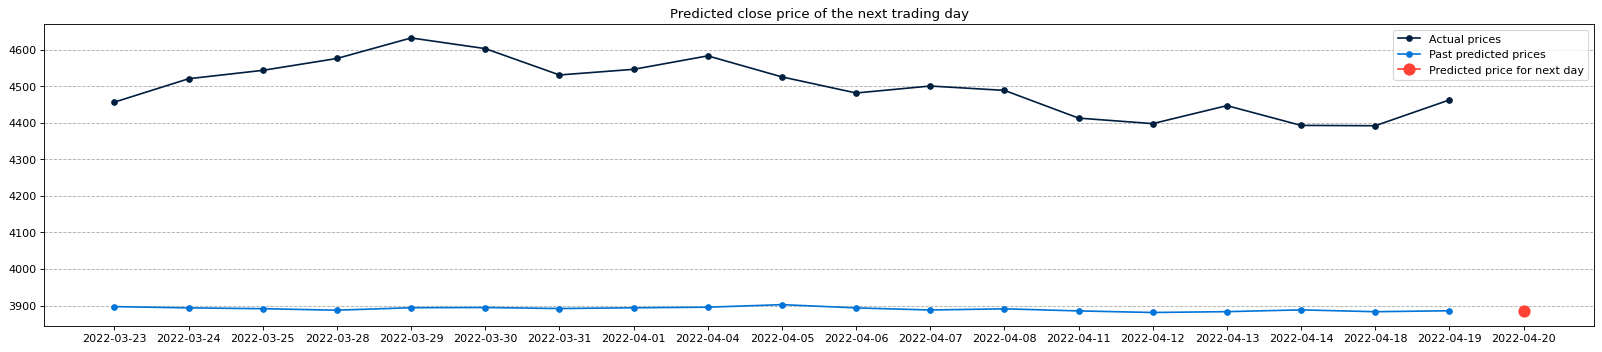

Predicted close price of the next trading day: 3885.87


In [ ]:
# predict on the unseen data, tomorrow's price 

model.eval()

#x = torch.tensor(SP500_x_unseen_modified).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
#x = torch.tensor(SP500_x_unseen_modified).float().to(config["training"]["device"]).unsqueeze(2) 
x = torch.tensor(SP500_x_unseen_modified).float().to(config["training"]["device"]).unsqueeze(0)
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction)[0]

if config["plots"]["show_plots"]:
        
    # prepare plots

    plot_range = 20
    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(SP500_y_val)[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = prediction

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot

    data_date = SP500_df["data_date"].to_numpy()
    plot_date_test = data_date[-plot_range:]
    #plot_date_test.append("next trading day")

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
    plt.title("Predicted close price of the next trading day")
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

print("Predicted close price of the next trading day:", round(prediction, 2))

In [ ]:
to_plot_data_y_val

array([4456.240234375, 4520.16015625, 4543.06005859375, 4575.52001953125,
       4631.60009765625, 4602.4501953125, 4530.41015625, 4545.85986328125,
       4582.64013671875, 4525.1201171875, 4481.14990234375,
       4500.2099609375, 4488.27978515625, 4412.52978515625,
       4397.4501953125, 4446.58984375, 4392.58984375, 4391.68994140625,
       4462.2099609375, None], dtype=object)

In [ ]:
to_plot_data_y_val_pred

array([3897.255265363805, 3893.8544150125326, 3891.5866735237482,
       3887.5221287984064, 3894.295735105722, 3894.8200050912656,
       3892.079230175016, 3894.11183586102, 3895.699692985265,
       3902.685197697273, 3893.8128924487364, 3888.0603983639453,
       3891.262302302902, 3885.5450452561936, 3881.218984567128,
       3883.547009961607, 3888.377436471461, 3883.3834910578507,
       3885.989793817954, None], dtype=object)

In [ ]:
data_date

array(['2014-03-27', '2014-03-28', '2014-03-31', ..., '2022-04-18',
       '2022-04-19', '2022-04-20'], dtype=object)

In [ ]:
date_df = pd.DataFrame(data_date[-plot_range:])
actual_df = pd.DataFrame(to_plot_data_y_val)
prediction_df = pd.DataFrame(to_plot_data_y_val_pred)

temp_result_set = pd.concat([date_df,                              
                            actual_df,
                            prediction_df],
                            axis=1)
print(temp_result_set)

             0            0            0
0   2022-03-23  4456.240234  3897.255265
1   2022-03-24  4520.160156  3893.854415
2   2022-03-25  4543.060059  3891.586674
3   2022-03-28   4575.52002  3887.522129
4   2022-03-29  4631.600098  3894.295735
5   2022-03-30  4602.450195  3894.820005
6   2022-03-31  4530.410156   3892.07923
7   2022-04-01  4545.859863  3894.111836
8   2022-04-04  4582.640137  3895.699693
9   2022-04-05  4525.120117  3902.685198
10  2022-04-06  4481.149902  3893.812892
11  2022-04-07  4500.209961  3888.060398
12  2022-04-08  4488.279785  3891.262302
13  2022-04-11  4412.529785  3885.545045
14  2022-04-12  4397.450195  3881.218985
15  2022-04-13  4446.589844   3883.54701
16  2022-04-14  4392.589844  3888.377436
17  2022-04-18  4391.689941  3883.383491
18  2022-04-19  4462.209961  3885.989794
19  2022-04-20         None         None


In [ ]:
type(temp_result_set)

pandas.core.frame.DataFrame

In [ ]:
temp_result_set.columns = ['Date', 'SP500', 'Predictions']

In [ ]:
temp_result_set.head()

,Date,SP500,Predictions
0,2022-03-23,4456.240234,3897.255265
1,2022-03-24,4520.160156,3893.854415
2,2022-03-25,4543.060059,3891.586674
3,2022-03-28,4575.52002,3887.522129
4,2022-03-29,4631.600098,3894.295735


In [ ]:
temp_result_set['Predictions_5Ds'] = temp_result_set.shift(-5)['Predictions']
temp_result_set['pct_Price'] = temp_result_set['Predictions_5Ds'] / temp_result_set['SP500'] - 1
temp_result_set['SP500_5Ds'] = temp_result_set.shift(-5)['SP500']

In [ ]:
temp_result_set.head()

,Date,SP500,Predictions,Predictions_5Ds,pct_Price,SP500_5Ds
0,2022-03-23,4456.240234,3897.255265,3894.820005,-0.125985,4602.450195
1,2022-03-24,4520.160156,3893.854415,3892.07923,-0.138951,4530.410156
2,2022-03-25,4543.060059,3891.586674,3894.111836,-0.142844,4545.859863
3,2022-03-28,4575.52002,3887.522129,3895.699693,-0.148578,4582.640137
4,2022-03-29,4631.600098,3894.295735,3902.685198,-0.157379,4525.120117


In [ ]:
def Action(x):
    if x > 0.10:
        return 1
    if x < -0.10:
        return -1
    else:
        return 0

In [ ]:
temp_result_set['Action'] = temp_result_set['pct_Price'].apply(lambda x: Action(x))

In [ ]:
temp_result_set['Profit'] = (temp_result_set['SP500_5Ds'] - temp_result_set['SP500']) * temp_result_set['Action']

In [ ]:
temp_result_set.head()

,Date,SP500,Predictions,Predictions_5Ds,pct_Price,SP500_5Ds,Action,Profit
0,2022-03-23,4456.240234,3897.255265,3894.820005,-0.125985,4602.450195,-1,-146.209961
1,2022-03-24,4520.160156,3893.854415,3892.07923,-0.138951,4530.410156,-1,-10.25
2,2022-03-25,4543.060059,3891.586674,3894.111836,-0.142844,4545.859863,-1,-2.799805
3,2022-03-28,4575.52002,3887.522129,3895.699693,-0.148578,4582.640137,-1,-7.120117
4,2022-03-29,4631.600098,3894.295735,3902.685198,-0.157379,4525.120117,-1,106.47998


In [ ]:
# Total Profit in 20 days
temp_result_set['Profit'].sum()

636.05078125